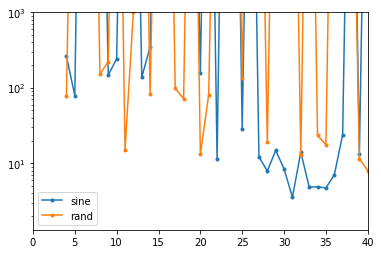

In [2]:
import sys
import os
import json
import numpy as np

from f0dl_bernox import *

%matplotlib inline
import matplotlib.pyplot as plt

json_fn = '/om2/user/msaddler/pitchnet/saved_models/test_ibm2/EVAL_bernox2005_HighSpec.json'
expt_dict = load_f0_expt_dict_from_json(json_fn)
expt_dict = add_f0_estimates_to_expt_dict(expt_dict)

sine_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=0)
rand_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=1)

sine_expt_dict = add_f0_judgments_to_expt_dict(sine_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)
rand_expt_dict = add_f0_judgments_to_expt_dict(rand_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)

sine_results_dict = compute_f0_thresholds_for_each_low_harm(sine_expt_dict, bin_width=1e-2)
rand_results_dict = compute_f0_thresholds_for_each_low_harm(rand_expt_dict, bin_width=1e-2)

plt.figure()
plt.semilogy(sine_results_dict['low_harm'], sine_results_dict['f0dl'], '.-', label='sine')
plt.semilogy(rand_results_dict['low_harm'], rand_results_dict['f0dl'], '.-', label='rand')
plt.ylim([None, 10e2])
plt.xlim([0, 40])
plt.legend()
plt.show()


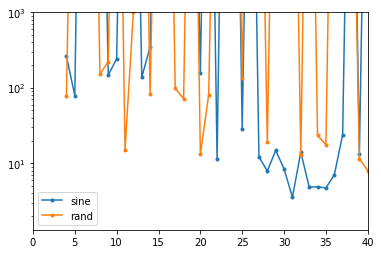

bins <class 'list'>
mu <class 'float'>
bin_means <class 'list'>
threshold_value <class 'float'>
sigma <class 'list'>
bin_width <class 'float'>
sigma_cov <class 'list'>


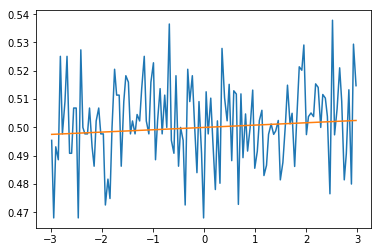

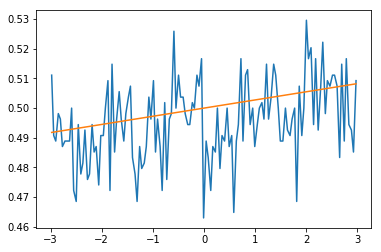

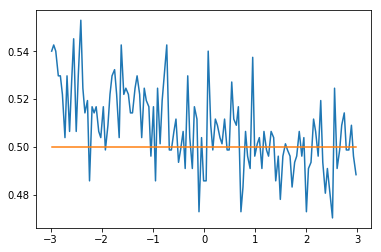

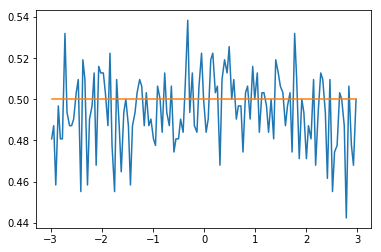

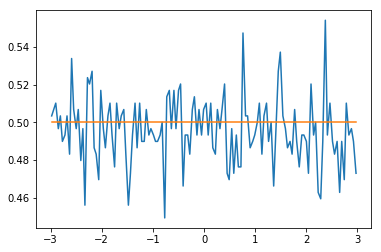

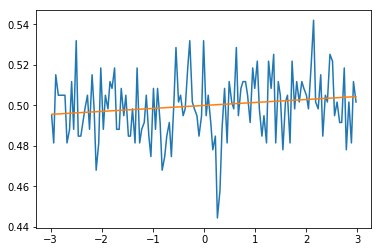

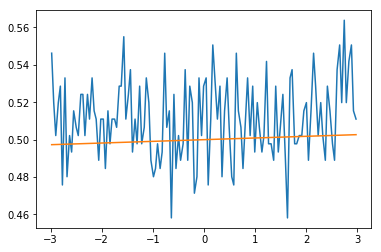

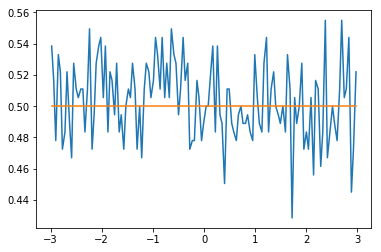

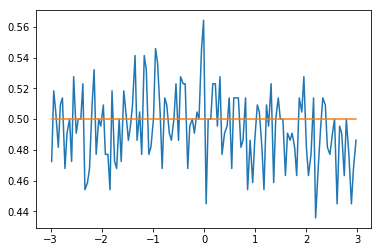

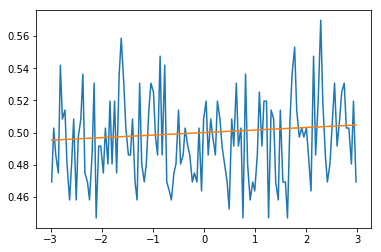

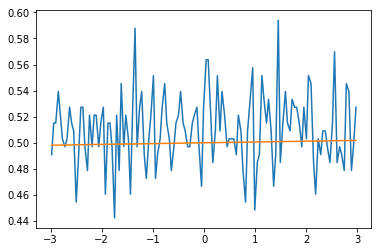

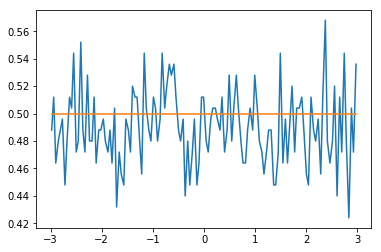

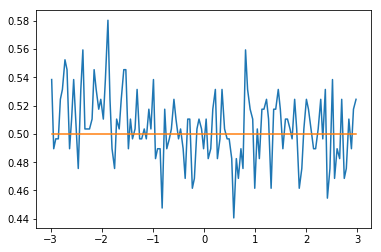

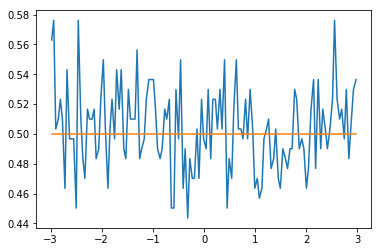

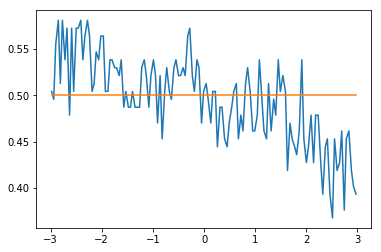

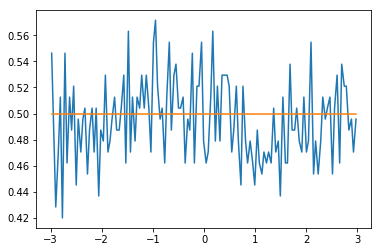

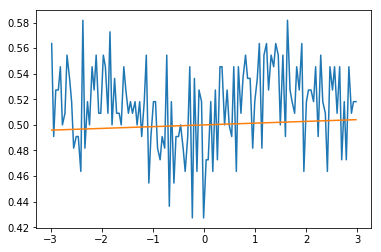

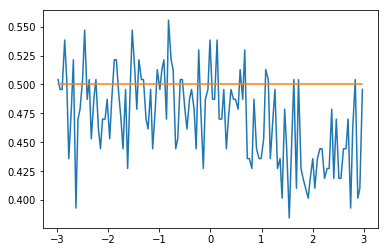

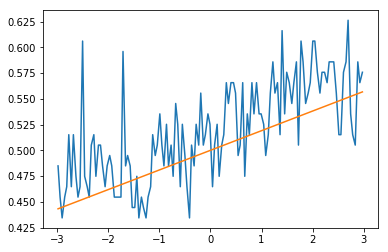

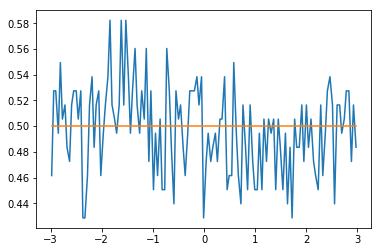

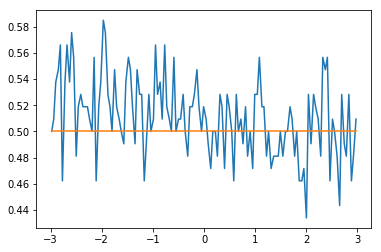

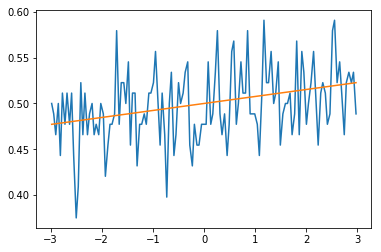

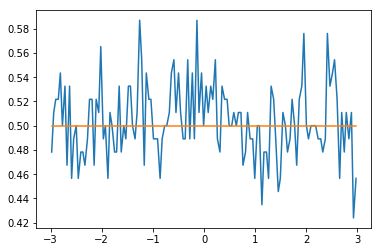

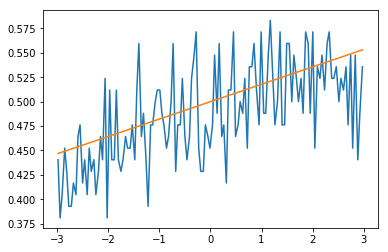

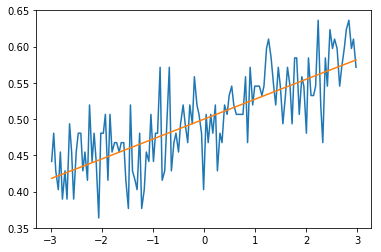

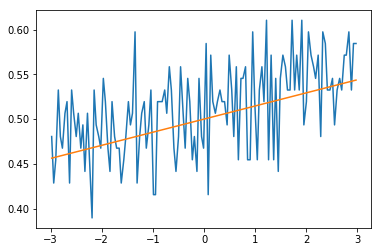

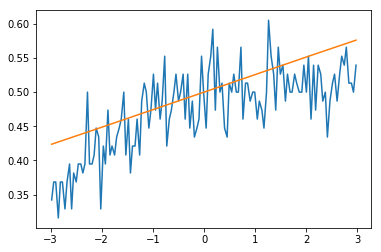

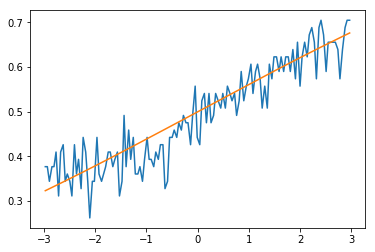

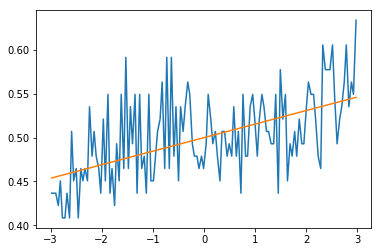

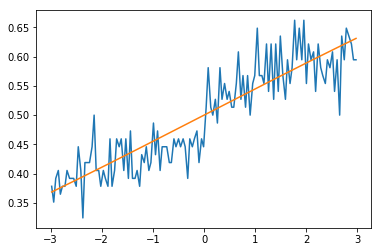

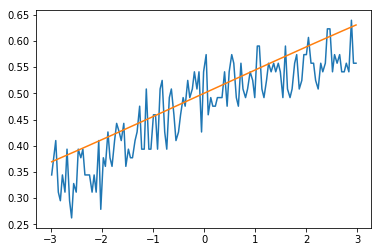

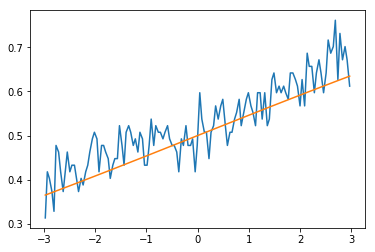

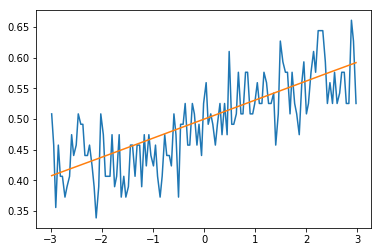

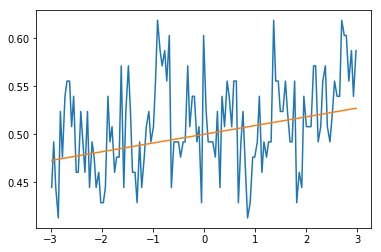

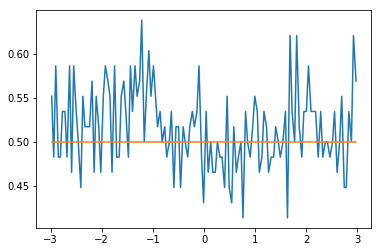

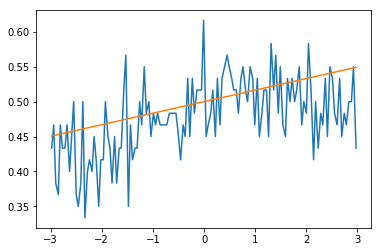

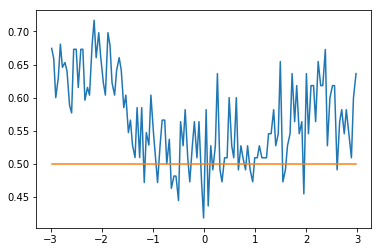

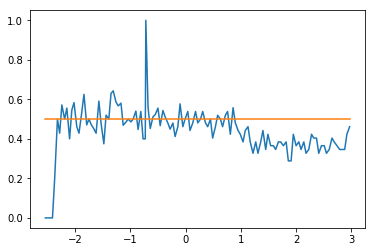

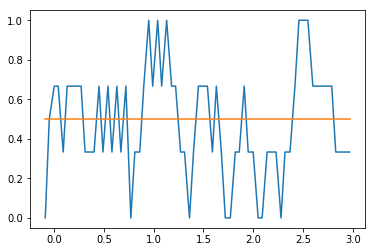

In [4]:
plt.figure()
plt.semilogy(sine_results_dict['low_harm'], sine_results_dict['f0dl'], '.-', label='sine')
plt.semilogy(rand_results_dict['low_harm'], rand_results_dict['f0dl'], '.-', label='rand')
plt.ylim([None, 10e2])
plt.xlim([0, 40])
plt.legend()
plt.show()

for key in sine_results_dict['psychometric_functions'].keys():
    print(key, type(sine_results_dict['psychometric_functions'][key]))

normcdf = lambda x, sigma: scipy.stats.norm(sine_results_dict['psychometric_functions']['mu'], sigma).cdf(x)

for idx in range(len(sine_results_dict['low_harm'])):
    plt.figure()
    x = sine_results_dict['psychometric_functions']['bins'][idx]
    y = sine_results_dict['psychometric_functions']['bin_means'][idx]
    plt.plot(x, y)
    plt.plot(x, normcdf(x, sine_results_dict['psychometric_functions']['sigma'][idx]))
    plt.show()

In [ ]:
json_fn = '/om2/user/msaddler/pitchnet/saved_models/test_ibm2/EVAL_bernox2005_LowSpec.json'
expt_dict = load_f0_expt_dict_from_json(json_fn)
expt_dict = add_f0_estimates_to_expt_dict(expt_dict)

sine_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=0)
rand_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=1)

sine_expt_dict = add_f0_judgments_to_expt_dict(sine_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)
rand_expt_dict = add_f0_judgments_to_expt_dict(rand_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)

sine_results_dict = add_f0_thresholds_to_expt_dict(sine_expt_dict, bin_width=1e-2)
rand_results_dict = add_f0_thresholds_to_expt_dict(rand_expt_dict, bin_width=1e-2)

plt.figure()
plt.semilogy(sine_results_dict['low_harm'], sine_results_dict['f0dl'], '.-', label='sine')
plt.semilogy(rand_results_dict['low_harm'], rand_results_dict['f0dl'], '.-', label='rand')
plt.ylim([None, 10e2])
plt.xlim([0, 40])
plt.legend()
plt.show()

json_fn = '/om2/user/msaddler/pitchnet/saved_models/test_ibm2/EVAL_bernox2005_HighSpec.json'
expt_dict = load_f0_expt_dict_from_json(json_fn)
expt_dict = add_f0_estimates_to_expt_dict(expt_dict)

sine_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=0)
rand_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=1)

sine_expt_dict = add_f0_judgments_to_expt_dict(sine_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)
rand_expt_dict = add_f0_judgments_to_expt_dict(rand_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)

sine_results_dict = add_f0_thresholds_to_expt_dict(sine_expt_dict, bin_width=1e-2)
rand_results_dict = add_f0_thresholds_to_expt_dict(rand_expt_dict, bin_width=1e-2)

plt.figure()
plt.semilogy(sine_results_dict['low_harm'], sine_results_dict['f0dl'], '.-', label='sine')
plt.semilogy(rand_results_dict['low_harm'], rand_results_dict['f0dl'], '.-', label='rand')
plt.ylim([None, 10e2])
plt.xlim([0, 40])
plt.legend()
plt.show()


In [ ]:
json_fn = '/om2/user/msaddler/pitchnet/saved_models/test_ibm0/EVAL_bernox2005_LowSpec.json'
expt_dict = load_f0_expt_dict_from_json(json_fn)
expt_dict = add_f0_estimates_to_expt_dict(expt_dict)

sine_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=0)
rand_expt_dict = get_sub_expt_dict_by_key_value(expt_dict, split_key='phase_mode', split_value=1)

sine_expt_dict = add_f0_judgments_to_expt_dict(sine_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)
rand_expt_dict = add_f0_judgments_to_expt_dict(rand_expt_dict, f0_true_key='f0', f0_pred_key='f0_pred', max_pct_diff=3)

sine_results_dict = add_f0_thresholds_to_expt_dict(sine_expt_dict, bin_width=1e-2)
rand_results_dict = add_f0_thresholds_to_expt_dict(rand_expt_dict, bin_width=1e-2)

plt.figure()
plt.semilogy(sine_results_dict['low_harm'], sine_results_dict['f0dl'], '.-', label='sine')
plt.semilogy(rand_results_dict['low_harm'], rand_results_dict['f0dl'], '.-', label='rand')
plt.ylim([None, 10e2])
plt.xlim([0, 40])
plt.legend()
plt.show()
